# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

Preparing data

In [2]:
file = 'data/wdbc.data'

df = pd.read_csv(file, header = None)
cols = ["id","diagnosis"] + [
    f"{feat}_{stat}"
    for stat in ["mean","se","worst"]
    for feat in ["radius","texture","perimeter","area",
                 "smoothness","compactness","concavity",
                 "concave_points","symmetry","fractal_dimension"]
]
df.columns = cols
df["diagnosis"] = df["diagnosis"].map({"B": 0.0, "M": 1.0})

All data is float exept the target: diagnosis. There aren't missing values.

In [3]:
df.info()
df.head(3)
df.describe()
print("Missing Values:",df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    float64
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Data is more or less Gaussian, but a Standard scaler should be applied.

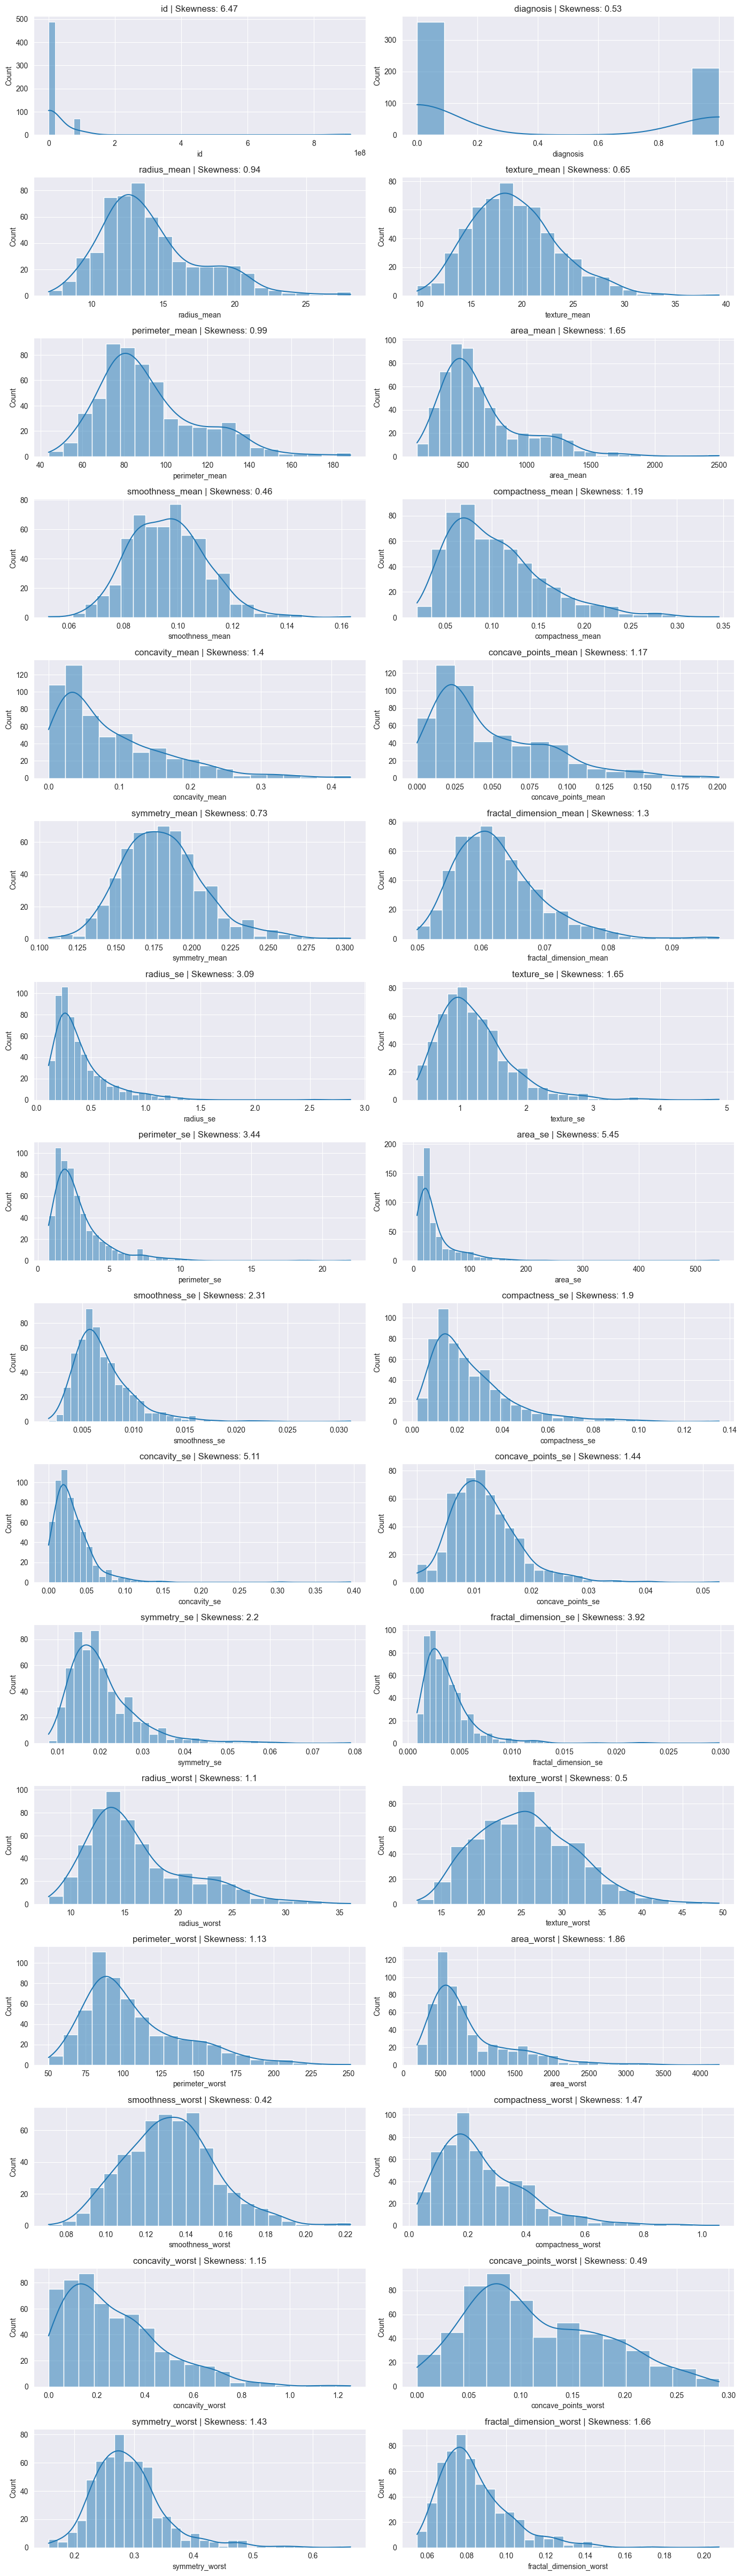

In [4]:
# Variables' Histogram

sns.set_style("darkgrid")

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

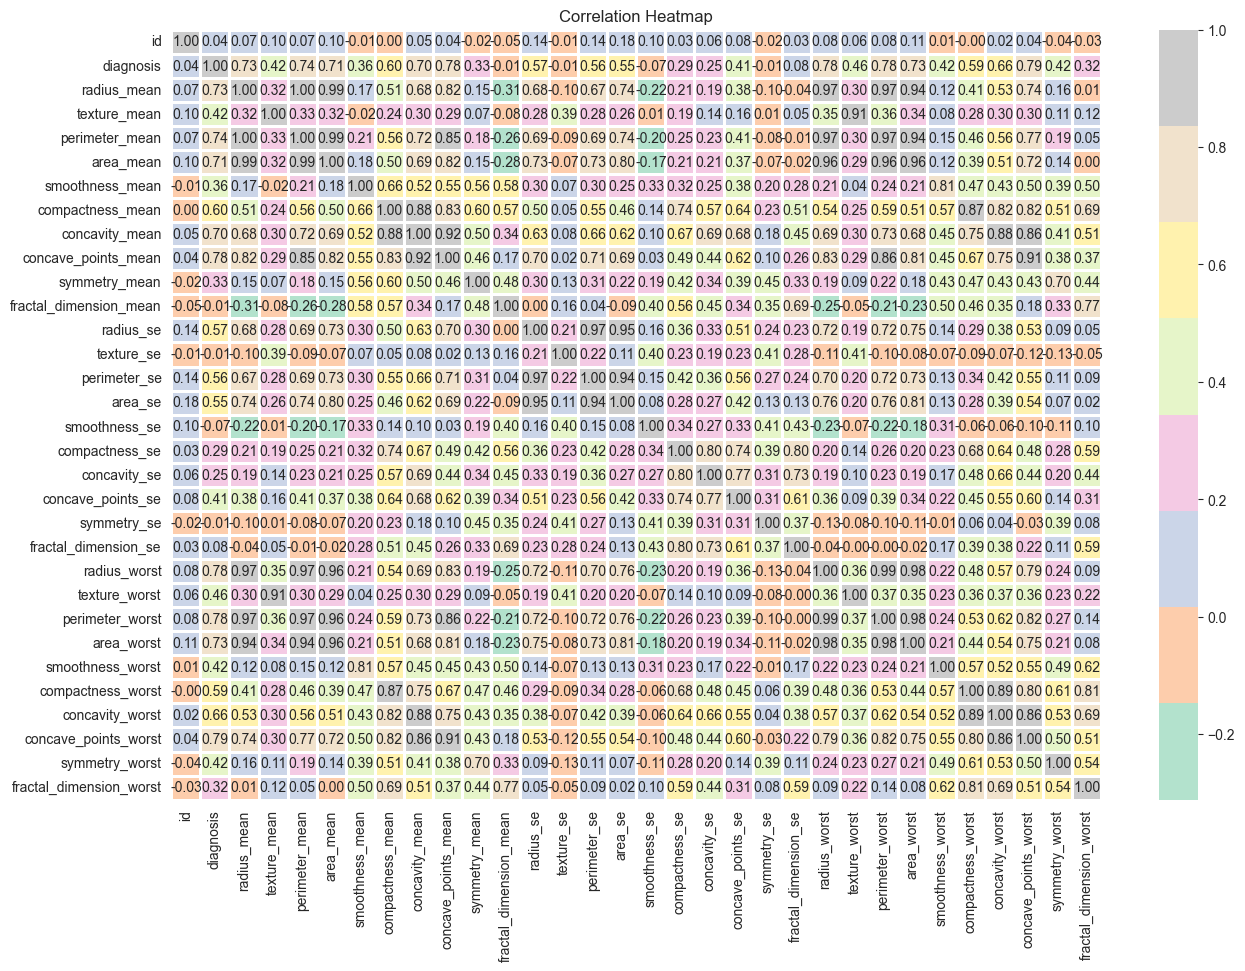

In [5]:
# Correlation map

plt.figure(figsize=(15, 10))

sns.heatmap(df[numerical_columns].corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

These are the most correlated variables with the target. We choose a threshold of 0.3.

In [6]:
from scipy.stats import pointbiserialr

correlations = {}

for col in df.drop(columns=["diagnosis","id"]).columns:
    r, p = pointbiserialr(df["diagnosis"], df[col].astype(float))
    correlations[col] = r

pd.Series(correlations)[abs(pd.Series(correlations)) > 0.3].sort_values(ascending=False)


concave_points_worst       0.793566
perimeter_worst            0.782914
concave_points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave_points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
dtype: float64

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(
    df,
    features,
    target_col,
    target_labels=None,
    plot_type="kde",
    figsize=(7, 2.5)
):
    """
    Plot class-wise distributions for selected features (publication-ready).

    Parameters
    ----------
    df : pd.DataFrame
        Dataset
    features : list of str
        Selected feature names
    target_col : str
        Target column name
    target_labels : dict, optional
        Mapping {0: 'Benign', 1: 'Malignant'}
    plot_type : str
        'kde' or 'box'
    figsize : tuple
        Size per subplot
    """

    sns.set_theme(style="whitegrid", context="paper")

    n_features = len(features)
    fig, axes = plt.subplots(
        n_features,
        1,
        figsize=(figsize[0], figsize[1] * n_features),
        sharex=False
    )

    if n_features == 1:
        axes = [axes]

    for ax, feature in zip(axes, features):

        if plot_type == "kde":
            sns.kdeplot(
                data=df,
                x=feature,
                hue=target_col,
                fill=True,
                common_norm=False,
                alpha=0.45,
                linewidth=1.5,
                ax=ax
            )

        elif plot_type == "box":
            sns.boxplot(
                data=df,
                x=target_col,
                y=feature,
                width=0.5,
                ax=ax
            )

        ax.set_title(feature.replace("_", " ").title(), fontsize=11)
        ax.set_ylabel("Density" if plot_type == "kde" else feature)
        ax.set_xlabel("")

        # Remove per-axis legend (we add a shared one later)
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # ---- Shared legend ----
    handles, labels = axes[0].get_legend_handles_labels()

    if target_labels:
        labels = [target_labels.get(int(l), l) for l in labels]

    fig.legend(
        handles,
        labels,
        title="Diagnosis",
        loc="upper center",
        ncol=len(labels),
        frameon=False
    )

    fig.suptitle(
        "Feature Distributions by Diagnostic Class",
        fontsize=13,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


ValueError: number sections must be larger than 0.

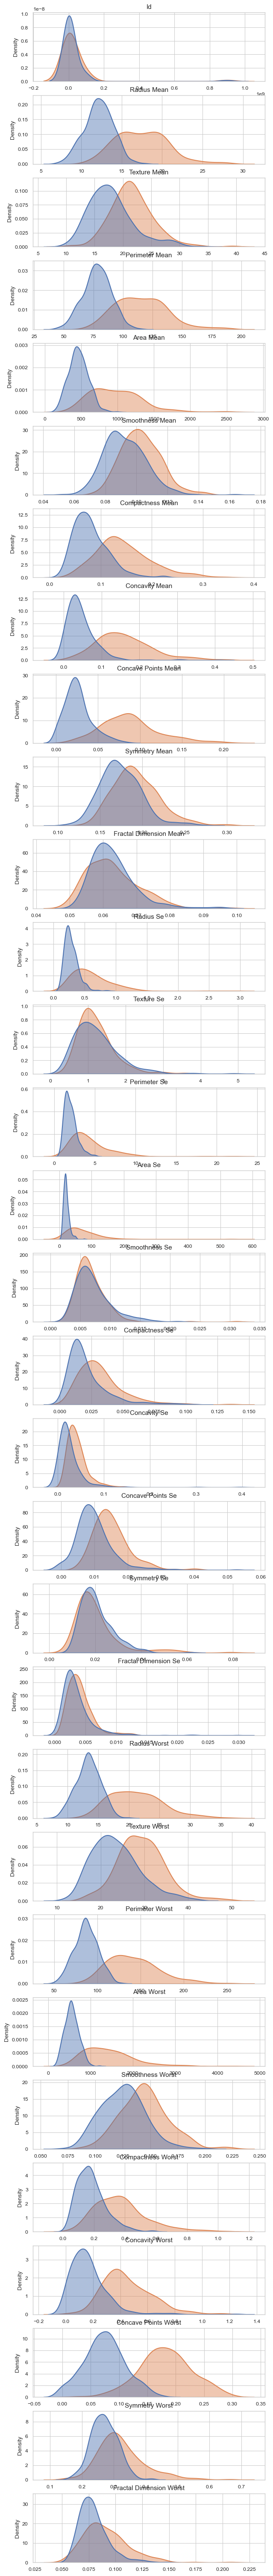

In [18]:
plot_columns = [col for col in numerical_columns if col != "diagnosis"]


plot_feature_distributions(
    df=df,
    features=plot_columns,
    target_col="diagnosis",
    target_labels={0: "Benign", 1: "Malignant"},
    plot_type="kde"
)